<a href="https://colab.research.google.com/github/SophieD517/MTL/blob/main/Copy_of_Sine_ConvNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%rm -rf /content/logs

In [1]:
!pip install pytorch-lightning
!pip install wandb
!wandb login
import wandb
import seaborn as sns
import pytorch_lightning as pl
from torch import nn, Tensor, optim
import torch.nn.functional as F
from torchmetrics import Accuracy
import os
import torch
import numpy as np
import pandas as pd
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
import math as m
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="Sine_ConvNN")


os.environ['PYTHONHASHSEED'] = str(13)
torch.manual_seed(13)
np.random.seed(13)


# # https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
# class FastTensorDataLoader:
#     """
#     A DataLoader-like object for a set of tensors that can be much faster than
#     TensorDataset + DataLoader because dataloader grabs individual indices of
#     the dataset and calls cat (slow).
#     Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
#     """
#     def __init__(self, *tensors, batch_size=32, shuffle=False):
#         """
#         Initialize a FastTensorDataLoader.
#         :param *tensors: tensors to store. Must have the same length @ dim 0.
#         :param batch_size: batch size to load.
#         :param shuffle: if True, shuffle the data *in-place* whenever an
#             iterator is created out of this object.
#         :returns: A FastTensorDataLoader.
#         """
#         assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
#         self.tensors = tensors

#         self.dataset_len = self.tensors[0].shape[0]
#         self.batch_size = batch_size
#         self.shuffle = shuffle

#         # Calculate # batches
#         n_batches, remainder = divmod(self.dataset_len, self.batch_size)
#         if remainder > 0:
#             n_batches += 1
#         self.n_batches = n_batches
#     def __iter__(self):
#         if self.shuffle:
#             r = torch.randperm(self.dataset_len)
#             self.tensors = [t[r] for t in self.tensors]
#         self.i = 0
#         return self

#     def __next__(self):
#         if self.i >= self.dataset_len:
#             raise StopIteration
#         batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
#         self.i += self.batch_size
#         return batch

#     def __len__(self):
#         return self.n_batches


def plot_recon(x_test, recon, title=''):
  plt.style.use('seaborn-whitegrid')
  fig, ax = plt.subplots(1, 1)
  x = [x for x in np.arange(-10*np.pi, 10*np.pi, np.pi/10)]
  sam = [0,1,2]
  colors = ['mistyrose', '#ccffb3', '#ADD8E6']
  a = 0
  for i in sam:
    plt.plot(x, x_test.detach().numpy().tolist()[i], color=colors[a], linewidth=5)
    a+=1
  colors = ['salmon', 'darkolivegreen', 'darkcyan']
  a = 0
  for i in sam:
    plt.plot(x, recon.detach().numpy().tolist()[i], '--', color=colors[a], linewidth=1)
    a+=1
  fig.set_size_inches(12, 8)
  plt.ylim(-1, 1)
  plt.xlim(-10*np.pi, 10*np.pi)
  plt.title(title)
  plt.show()

def plot_ex(orig, recon, text='', title='Epoch ', epoch='', col='black'):
  a = np.random.randint(low=0, high=200)
  fig, ax = plt.subplots()
  x = orig[:, a:a+1].squeeze().detach()
  y = recon[:, a:a+1].squeeze().detach()
  ax.set_ylabel('recon')
  ax.set_xlabel('orig')
  ax.set_title(title+epoch, color=col)
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  ax.scatter(x, y, s=1, color='red')
  dist = np.array([-1, 0, 1])
  ax.plot(dist, dist, color='#d3d3d3', linewidth=1)
  a, b = np.polyfit(x, y, 1)
  ax.plot(dist, a*dist+b, color='red', linewidth=1)
  plt.text(-.9, .75, text, color=col)   

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 4.3 MB/s 
     |████████████████████████████████| 140 kB 46.3 MB/s 
     |████████████████████████████████| 419 kB 49.6 MB/s 
     |████████████████████████████████| 596 kB 38.5 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 271 kB 56.4 MB/s 
     |████████████████████████████████| 94 kB 2.7 MB/s 
     |████████████████████████████████| 144 kB 48.8 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 146 kB 64.0 MB/s 
     |████████████████████████████████| 181 kB 70.8 MB/s 
     |█████████████

wandb: Currently logged in as: sophied. Use `wandb login --relogin` to force relogin


#Generate Data

In [2]:
def gen_data(num=1000):
  a = np.random.uniform(low=-5, high=5, size=num).tolist()
  b = np.random.uniform(low=-5, high=5, size=num).tolist()
  h = np.random.uniform(low=-5, high=5, size=num).tolist()
  k = np.random.uniform(low=-5, high=5, size=num).tolist()

  mlist = []
  for i, t in enumerate(a):
    # mlist.append([a[i]+b[i]+h[i]+k[i]*x for x in np.arange(-10*np.pi, 10*np.pi, np.pi/10)])
    mlist.append([a[i]*np.sin(b[i]*x-h[i])+k[i] for x in np.arange(-10*np.pi, 10*np.pi, np.pi/10)])
  data = pd.DataFrame(mlist)

  data['a'] = a
  data['b'] = b
  data['h'] = h
  data['k'] = k

  msk = np.random.rand(len(data)) < 0.7
  train = data[msk]
  p2 = data[~msk]
  msk2 = np.random.rand(len(p2)) < 0.5
  validate = p2[~msk2]
  test = p2[msk2]

  train.to_csv('train.csv')
  test.to_csv('test.csv')
  validate.to_csv('val.csv')

  return

  train_data = torch.tensor(train.values, requires_grad=True, dtype=torch.float32).mul(0.1)
  test_data = torch.tensor(test.values, requires_grad=True, dtype=torch.float32).mul(0.1)
  self.val_data = torch.tensor(validate.values, requires_grad=True, dtype=torch.float32).mul(0.1)

In [3]:
gen_data(num=10000)

#PL

In [4]:
class Starlight(pl.LightningModule):
  def __init__(self, latent_dim, drop_rate):
    super().__init__()

    self.enc_conv1 = torch.nn.Conv1d(in_channels=1, out_channels=5, kernel_size=3, padding=2, stride=1)
    self.enc_pool1 = torch.nn.MaxPool1d(kernel_size=3, padding=1)
    self.enc_conv2 = torch.nn.Conv1d(in_channels=5, out_channels=8, kernel_size=2, padding=2, stride=1)
    self.enc_pool2 = torch.nn.MaxPool1d(kernel_size=5, padding=2)
    self.enc_lin1 = torch.nn.Linear(120, latent_dim)

    self.dec_lin1 = torch.nn.Linear(latent_dim, 50)
    self.dec_conv1 = torch.nn.ConvTranspose1d(in_channels=2, out_channels=3, kernel_size=5, padding=2)
    self.dec_conv2 = torch.nn.ConvTranspose1d(in_channels=3, out_channels=5, kernel_size=5, padding=2)
    self.dec_lin2 = torch.nn.Linear(125, 200)

    self.dropout = torch.nn.Dropout(drop_rate)
    

  def encoder(self, x):
    x = x.unsqueeze(dim=1) #(bs, 1 channel, signal length 200)
    x = self.enc_conv1(x)
    x = torch.nn.functional.leaky_relu(x)
    x = self.enc_pool1(x)
    x = self.enc_conv2(x)
    x = torch.nn.functional.leaky_relu(x)
    x = self.enc_pool2(x)
    x = self.dropout(x)
    x = torch.flatten(x, start_dim=1)
    x = self.enc_lin1(x)
    return x

  def decoder(self, x):
    # x = self.dec_lin1(x)
    # x = torch.nn.functional.leaky_relu(x)
    x = self.dec_conv1(x.view(x.shape[0], 2, 25)) ##use view
    x = torch.nn.functional.leaky_relu(x)
    x = self.dec_conv2(x)
    x = torch.nn.functional.leaky_relu(x)
    x = torch.flatten(x, start_dim=1)
    
    x = self.dec_lin2(x)
    return x


  def forward(self, x): 
    ls = self.encoder(x)
    return ls, self.decoder(ls)

class Sine_ConvNN(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.save_hyperparameters()
    self.model = Starlight(50, 0)
    # self.model = Conv3FC1AE(10, 13, 0.1)
    self.bs=64

  #########
  # STEPS #
  #########

  def training_step(self, x, batch_idx, drop_last=True):
    ls, x_hat = self.model(x)
    loss = nn.MSELoss()(x_hat, x)
    wandb.log({"train_loss": loss})
    self.log('train_loss', loss)
    return loss

  def validation_step(self, x, batch_idx, drop_last=True): 
    ls, x_hat = self.model(x)
    loss = nn.MSELoss()(x_hat, x)
    # if np.random.uniform(low=0, high=1)<0.01:
    #   plot_ex(x, x_hat, text='loss: '+str(loss))
    print(loss)
    wandb.log({'val_loss': loss})
    self.log("val_loss", loss)

  def test_step(self, x, batch_idx):
    ls, x_hat = self.model(x)
    loss = nn.MSELoss()(x_hat, x)
    plot_recon(x, x_hat)
    # plot_ex(x, x_hat)
    # self.log("test_loss", loss, prog_bar=True)
    return ls, x_hat

  ########
  # MISC #
  ########

  def backward(self, loss, optimizer, optimizer_idx):
    loss.backward(retain_graph=True)

  def configure_optimizers(self, lr=0.0001):
    return optim.Adam(self.parameters(), lr=lr)

  def cross_validate(self, x, y, num_folds, epochs):
    x_train, x_test = np.array_split(x, [int(0.8 * x.shape[0])], axis=0) #split x into training and testing data
    y_train, y_test = np.array_split(y, [int(0.8 * y.shape[0])], axis=0) #split y into training and testing data
    x_folds = np.array_split(x_train, num_folds, axis=0) #split the training x data into folds
    y_folds = np.array_split(y_train, num_folds, axis=0) #split the training y data into folds
    validation_losses = [] #initialize validation_losses as an empty list
    for i in range(num_folds): #loops through the number of folds
      self.reset() #reset the model
      x_combined = np.concatenate(x_folds[:i]+x_folds[i+1:], axis=0) #combine all x folds except for the validation fold
      y_combined = np.concatenate(y_folds[:i]+y_folds[i+1:], axis=0) #combine all y folds except for the validation fold
      x_validation = x_folds[i] #define the validation x data as the selected x fold
      y_validation = y_folds[i] #define the validation y data as the selected y fold
      self.train(x_combined, y_combined, epochs) #train the model on the combined data
      validation_loss = self.validate(x_validation, y_validation) #validate the model on the validation data
      validation_losses.append(validation_loss) #append the validation loss to the list of validation losses
    self.reset() #reset the model
    validation_loss = np.mean(validation_losses) #calculate average validation loss
    self.train(x_train, y_train, epochs) #train the model on all the training data
    test_loss = self.validate(x_test, y_test) #evaluate the performance of the model on the test data
    print(f"Validation Loss: {validation_loss}, Test Loss: {test_loss}") #print our validation and test loss
    return validation_loss, test_loss # return validation and test loss

  ########
  # DATA #
  ########

  def train_dataloader(self):
    data = torch.tensor((pd.read_csv('train.csv').drop(columns=['Unnamed: 0', 'a', 'b', 'h', 'k'])).values, requires_grad=True, dtype=torch.float32).mul(0.1)
    return DataLoader(data, batch_size=self.bs, shuffle=True)

  def val_dataloader(self):
    data = torch.tensor((pd.read_csv('val.csv').drop(columns=['Unnamed: 0', 'a', 'b', 'h', 'k'])).values, requires_grad=True, dtype=torch.float32).mul(0.1)
    return DataLoader(data, batch_size=self.bs)

  def test_dataloader(self):
    data = torch.tensor((pd.read_csv('test.csv').drop(columns=['Unnamed: 0', 'a', 'b', 'h', 'k'])).values, requires_grad=True, dtype=torch.float32).mul(0.1)
    return DataLoader(data, batch_size=self.bs)


In [5]:
wandb_logger = WandbLogger(project="Sine_ConvNN")
wandb.init(project="Sine_ConvNN", entity="sophied")
model = Sine_ConvNN()
trainer = Trainer(
    accelerator="auto",
    devices=1,
  max_epochs=100,
    callbacks=[TQDMProgressBar(refresh_rate=20), EarlyStopping(monitor="val_loss", mode="min")],
    logger=wandb_logger,
    log_every_n_steps=1
)
trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | Starlight | 34.0 K
------------------------------------
34.0 K    Trainable params
0         Non-trainable params
34.0 K    Total params
0.136     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

tensor(0.1225)
tensor(0.1226)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

tensor(0.1171)
tensor(0.1168)
tensor(0.1152)
tensor(0.1405)
tensor(0.1176)
tensor(0.1276)
tensor(0.1229)
tensor(0.1085)
tensor(0.1182)
tensor(0.1479)
tensor(0.1170)
tensor(0.1293)
tensor(0.1200)
tensor(0.1016)
tensor(0.1048)
tensor(0.1143)
tensor(0.1403)
tensor(0.1192)
tensor(0.1400)
tensor(0.1307)
tensor(0.1357)
tensor(0.1339)
tensor(0.1214)
tensor(0.1396)


Validation: 0it [00:00, ?it/s]

tensor(0.1016)
tensor(0.0995)
tensor(0.1026)
tensor(0.1225)
tensor(0.0982)
tensor(0.1148)
tensor(0.1042)
tensor(0.0928)
tensor(0.1010)
tensor(0.1267)
tensor(0.1002)
tensor(0.1088)
tensor(0.1061)
tensor(0.0904)
tensor(0.0922)
tensor(0.0995)
tensor(0.1194)
tensor(0.1042)
tensor(0.1262)
tensor(0.1123)
tensor(0.1189)
tensor(0.1132)
tensor(0.1075)
tensor(0.1200)


Validation: 0it [00:00, ?it/s]

tensor(0.0648)
tensor(0.0583)
tensor(0.0651)
tensor(0.0816)
tensor(0.0530)
tensor(0.0742)
tensor(0.0670)
tensor(0.0603)
tensor(0.0577)
tensor(0.0756)
tensor(0.0601)
tensor(0.0601)
tensor(0.0675)
tensor(0.0615)
tensor(0.0586)
tensor(0.0623)
tensor(0.0699)
tensor(0.0644)
tensor(0.0842)
tensor(0.0742)
tensor(0.0743)
tensor(0.0669)
tensor(0.0693)
tensor(0.0649)


Validation: 0it [00:00, ?it/s]

tensor(0.0559)
tensor(0.0512)
tensor(0.0529)
tensor(0.0705)
tensor(0.0430)
tensor(0.0629)
tensor(0.0605)
tensor(0.0525)
tensor(0.0450)
tensor(0.0605)
tensor(0.0501)
tensor(0.0465)
tensor(0.0562)
tensor(0.0538)
tensor(0.0494)
tensor(0.0540)
tensor(0.0578)
tensor(0.0517)
tensor(0.0711)
tensor(0.0643)
tensor(0.0623)
tensor(0.0543)
tensor(0.0602)
tensor(0.0462)


Validation: 0it [00:00, ?it/s]

tensor(0.0540)
tensor(0.0496)
tensor(0.0499)
tensor(0.0674)
tensor(0.0423)
tensor(0.0604)
tensor(0.0589)
tensor(0.0510)
tensor(0.0434)
tensor(0.0581)
tensor(0.0487)
tensor(0.0449)
tensor(0.0541)
tensor(0.0518)
tensor(0.0480)
tensor(0.0526)
tensor(0.0557)
tensor(0.0498)
tensor(0.0681)
tensor(0.0617)
tensor(0.0600)
tensor(0.0526)
tensor(0.0584)
tensor(0.0438)


Validation: 0it [00:00, ?it/s]

tensor(0.0530)
tensor(0.0483)
tensor(0.0482)
tensor(0.0660)
tensor(0.0414)
tensor(0.0591)
tensor(0.0579)
tensor(0.0496)
tensor(0.0422)
tensor(0.0568)
tensor(0.0478)
tensor(0.0442)
tensor(0.0529)
tensor(0.0503)
tensor(0.0472)
tensor(0.0519)
tensor(0.0549)
tensor(0.0489)
tensor(0.0669)
tensor(0.0602)
tensor(0.0593)
tensor(0.0517)
tensor(0.0578)
tensor(0.0429)


Validation: 0it [00:00, ?it/s]

tensor(0.0523)
tensor(0.0474)
tensor(0.0472)
tensor(0.0650)
tensor(0.0406)
tensor(0.0583)
tensor(0.0571)
tensor(0.0484)
tensor(0.0413)
tensor(0.0562)
tensor(0.0473)
tensor(0.0438)
tensor(0.0522)
tensor(0.0492)
tensor(0.0466)
tensor(0.0513)
tensor(0.0545)
tensor(0.0482)
tensor(0.0661)
tensor(0.0593)
tensor(0.0587)
tensor(0.0511)
tensor(0.0573)
tensor(0.0423)


Validation: 0it [00:00, ?it/s]

tensor(0.0518)
tensor(0.0466)
tensor(0.0464)
tensor(0.0642)
tensor(0.0400)
tensor(0.0576)
tensor(0.0564)
tensor(0.0474)
tensor(0.0406)
tensor(0.0556)
tensor(0.0468)
tensor(0.0435)
tensor(0.0517)
tensor(0.0483)
tensor(0.0460)
tensor(0.0507)
tensor(0.0541)
tensor(0.0477)
tensor(0.0654)
tensor(0.0585)
tensor(0.0583)
tensor(0.0508)
tensor(0.0569)
tensor(0.0419)


Validation: 0it [00:00, ?it/s]

tensor(0.0511)
tensor(0.0461)
tensor(0.0455)
tensor(0.0630)
tensor(0.0396)
tensor(0.0566)
tensor(0.0556)
tensor(0.0467)
tensor(0.0403)
tensor(0.0550)
tensor(0.0463)
tensor(0.0434)
tensor(0.0512)
tensor(0.0478)
tensor(0.0454)
tensor(0.0499)
tensor(0.0533)
tensor(0.0470)
tensor(0.0641)
tensor(0.0576)
tensor(0.0574)
tensor(0.0504)
tensor(0.0559)
tensor(0.0414)


Validation: 0it [00:00, ?it/s]

tensor(0.0505)
tensor(0.0452)
tensor(0.0446)
tensor(0.0620)
tensor(0.0390)
tensor(0.0558)
tensor(0.0546)
tensor(0.0458)
tensor(0.0397)
tensor(0.0543)
tensor(0.0457)
tensor(0.0429)
tensor(0.0506)
tensor(0.0468)
tensor(0.0446)
tensor(0.0492)
tensor(0.0528)
tensor(0.0465)
tensor(0.0632)
tensor(0.0566)
tensor(0.0568)
tensor(0.0500)
tensor(0.0552)
tensor(0.0410)


Validation: 0it [00:00, ?it/s]

tensor(0.0497)
tensor(0.0444)
tensor(0.0434)
tensor(0.0607)
tensor(0.0383)
tensor(0.0550)
tensor(0.0537)
tensor(0.0447)
tensor(0.0390)
tensor(0.0535)
tensor(0.0449)
tensor(0.0424)
tensor(0.0501)
tensor(0.0458)
tensor(0.0439)
tensor(0.0484)
tensor(0.0523)
tensor(0.0458)
tensor(0.0620)
tensor(0.0555)
tensor(0.0560)
tensor(0.0495)
tensor(0.0544)
tensor(0.0406)


Validation: 0it [00:00, ?it/s]

tensor(0.0484)
tensor(0.0435)
tensor(0.0422)
tensor(0.0591)
tensor(0.0378)
tensor(0.0539)
tensor(0.0523)
tensor(0.0437)
tensor(0.0385)
tensor(0.0525)
tensor(0.0441)
tensor(0.0418)
tensor(0.0497)
tensor(0.0447)
tensor(0.0429)
tensor(0.0474)
tensor(0.0513)
tensor(0.0453)
tensor(0.0605)
tensor(0.0542)
tensor(0.0549)
tensor(0.0491)
tensor(0.0532)
tensor(0.0402)


Validation: 0it [00:00, ?it/s]

tensor(0.0473)
tensor(0.0429)
tensor(0.0413)
tensor(0.0582)
tensor(0.0373)
tensor(0.0529)
tensor(0.0510)
tensor(0.0428)
tensor(0.0379)
tensor(0.0517)
tensor(0.0432)
tensor(0.0412)
tensor(0.0495)
tensor(0.0437)
tensor(0.0420)
tensor(0.0466)
tensor(0.0505)
tensor(0.0448)
tensor(0.0596)
tensor(0.0534)
tensor(0.0543)
tensor(0.0485)
tensor(0.0524)
tensor(0.0396)


Validation: 0it [00:00, ?it/s]

tensor(0.0459)
tensor(0.0420)
tensor(0.0405)
tensor(0.0567)
tensor(0.0367)
tensor(0.0511)
tensor(0.0496)
tensor(0.0417)
tensor(0.0373)
tensor(0.0506)
tensor(0.0418)
tensor(0.0406)
tensor(0.0491)
tensor(0.0426)
tensor(0.0410)
tensor(0.0459)
tensor(0.0496)
tensor(0.0443)
tensor(0.0588)
tensor(0.0526)
tensor(0.0538)
tensor(0.0471)
tensor(0.0513)
tensor(0.0380)


Validation: 0it [00:00, ?it/s]

tensor(0.0450)
tensor(0.0413)
tensor(0.0399)
tensor(0.0562)
tensor(0.0362)
tensor(0.0508)
tensor(0.0489)
tensor(0.0409)
tensor(0.0369)
tensor(0.0503)
tensor(0.0411)
tensor(0.0401)
tensor(0.0486)
tensor(0.0419)
tensor(0.0403)
tensor(0.0454)
tensor(0.0494)
tensor(0.0435)
tensor(0.0582)
tensor(0.0520)
tensor(0.0532)
tensor(0.0467)
tensor(0.0509)
tensor(0.0382)


Validation: 0it [00:00, ?it/s]

tensor(0.0446)
tensor(0.0411)
tensor(0.0397)
tensor(0.0560)
tensor(0.0362)
tensor(0.0505)
tensor(0.0486)
tensor(0.0407)
tensor(0.0368)
tensor(0.0500)
tensor(0.0409)
tensor(0.0400)
tensor(0.0484)
tensor(0.0415)
tensor(0.0399)
tensor(0.0450)
tensor(0.0490)
tensor(0.0434)
tensor(0.0577)
tensor(0.0518)
tensor(0.0530)
tensor(0.0463)
tensor(0.0506)
tensor(0.0382)


Validation: 0it [00:00, ?it/s]

tensor(0.0443)
tensor(0.0409)
tensor(0.0393)
tensor(0.0556)
tensor(0.0358)
tensor(0.0502)
tensor(0.0484)
tensor(0.0402)
tensor(0.0365)
tensor(0.0496)
tensor(0.0404)
tensor(0.0397)
tensor(0.0481)
tensor(0.0410)
tensor(0.0397)
tensor(0.0448)
tensor(0.0490)
tensor(0.0430)
tensor(0.0575)
tensor(0.0512)
tensor(0.0527)
tensor(0.0463)
tensor(0.0505)
tensor(0.0378)


Validation: 0it [00:00, ?it/s]

tensor(0.0441)
tensor(0.0407)
tensor(0.0391)
tensor(0.0554)
tensor(0.0356)
tensor(0.0500)
tensor(0.0482)
tensor(0.0400)
tensor(0.0363)
tensor(0.0493)
tensor(0.0402)
tensor(0.0396)
tensor(0.0479)
tensor(0.0407)
tensor(0.0394)
tensor(0.0445)
tensor(0.0488)
tensor(0.0428)
tensor(0.0572)
tensor(0.0509)
tensor(0.0526)
tensor(0.0461)
tensor(0.0504)
tensor(0.0377)


Validation: 0it [00:00, ?it/s]

tensor(0.0438)
tensor(0.0407)
tensor(0.0390)
tensor(0.0553)
tensor(0.0356)
tensor(0.0497)
tensor(0.0479)
tensor(0.0399)
tensor(0.0360)
tensor(0.0490)
tensor(0.0400)
tensor(0.0394)
tensor(0.0478)
tensor(0.0406)
tensor(0.0391)
tensor(0.0443)
tensor(0.0485)
tensor(0.0427)
tensor(0.0570)
tensor(0.0506)
tensor(0.0523)
tensor(0.0457)
tensor(0.0501)
tensor(0.0376)


Validation: 0it [00:00, ?it/s]

tensor(0.0436)
tensor(0.0405)
tensor(0.0388)
tensor(0.0551)
tensor(0.0355)
tensor(0.0495)
tensor(0.0478)
tensor(0.0397)
tensor(0.0359)
tensor(0.0487)
tensor(0.0397)
tensor(0.0393)
tensor(0.0476)
tensor(0.0403)
tensor(0.0391)
tensor(0.0441)
tensor(0.0485)
tensor(0.0425)
tensor(0.0568)
tensor(0.0503)
tensor(0.0522)
tensor(0.0456)
tensor(0.0499)
tensor(0.0375)


Validation: 0it [00:00, ?it/s]

tensor(0.0435)
tensor(0.0406)
tensor(0.0387)
tensor(0.0549)
tensor(0.0355)
tensor(0.0493)
tensor(0.0477)
tensor(0.0396)
tensor(0.0357)
tensor(0.0485)
tensor(0.0397)
tensor(0.0391)
tensor(0.0474)
tensor(0.0401)
tensor(0.0389)
tensor(0.0439)
tensor(0.0482)
tensor(0.0425)
tensor(0.0566)
tensor(0.0501)
tensor(0.0521)
tensor(0.0452)
tensor(0.0496)
tensor(0.0374)


Validation: 0it [00:00, ?it/s]

tensor(0.0433)
tensor(0.0404)
tensor(0.0386)
tensor(0.0548)
tensor(0.0353)
tensor(0.0492)
tensor(0.0474)
tensor(0.0394)
tensor(0.0355)
tensor(0.0482)
tensor(0.0394)
tensor(0.0390)
tensor(0.0474)
tensor(0.0400)
tensor(0.0388)
tensor(0.0437)
tensor(0.0482)
tensor(0.0423)
tensor(0.0565)
tensor(0.0498)
tensor(0.0520)
tensor(0.0452)
tensor(0.0496)
tensor(0.0374)


Validation: 0it [00:00, ?it/s]

tensor(0.0432)
tensor(0.0404)
tensor(0.0385)
tensor(0.0547)
tensor(0.0353)
tensor(0.0491)
tensor(0.0473)
tensor(0.0393)
tensor(0.0354)
tensor(0.0480)
tensor(0.0393)
tensor(0.0389)
tensor(0.0472)
tensor(0.0398)
tensor(0.0386)
tensor(0.0436)
tensor(0.0480)
tensor(0.0423)
tensor(0.0563)
tensor(0.0496)
tensor(0.0518)
tensor(0.0449)
tensor(0.0494)
tensor(0.0373)


Validation: 0it [00:00, ?it/s]

tensor(0.0432)
tensor(0.0404)
tensor(0.0384)
tensor(0.0546)
tensor(0.0352)
tensor(0.0489)
tensor(0.0472)
tensor(0.0392)
tensor(0.0352)
tensor(0.0478)
tensor(0.0392)
tensor(0.0388)
tensor(0.0471)
tensor(0.0397)
tensor(0.0385)
tensor(0.0434)
tensor(0.0478)
tensor(0.0422)
tensor(0.0562)
tensor(0.0494)
tensor(0.0517)
tensor(0.0447)
tensor(0.0492)
tensor(0.0372)


Validation: 0it [00:00, ?it/s]

tensor(0.0431)
tensor(0.0403)
tensor(0.0383)
tensor(0.0545)
tensor(0.0351)
tensor(0.0488)
tensor(0.0472)
tensor(0.0391)
tensor(0.0351)
tensor(0.0476)
tensor(0.0391)
tensor(0.0387)
tensor(0.0470)
tensor(0.0395)
tensor(0.0384)
tensor(0.0434)
tensor(0.0478)
tensor(0.0421)
tensor(0.0561)
tensor(0.0492)
tensor(0.0516)
tensor(0.0447)
tensor(0.0491)
tensor(0.0371)


Validation: 0it [00:00, ?it/s]

tensor(0.0430)
tensor(0.0403)
tensor(0.0382)
tensor(0.0545)
tensor(0.0351)
tensor(0.0488)
tensor(0.0470)
tensor(0.0391)
tensor(0.0350)
tensor(0.0474)
tensor(0.0390)
tensor(0.0386)
tensor(0.0469)
tensor(0.0394)
tensor(0.0382)
tensor(0.0433)
tensor(0.0476)
tensor(0.0421)
tensor(0.0561)
tensor(0.0490)
tensor(0.0515)
tensor(0.0445)
tensor(0.0488)
tensor(0.0369)


Validation: 0it [00:00, ?it/s]

tensor(0.0430)
tensor(0.0402)
tensor(0.0381)
tensor(0.0543)
tensor(0.0349)
tensor(0.0486)
tensor(0.0470)
tensor(0.0390)
tensor(0.0349)
tensor(0.0473)
tensor(0.0388)
tensor(0.0385)
tensor(0.0468)
tensor(0.0393)
tensor(0.0381)
tensor(0.0432)
tensor(0.0475)
tensor(0.0420)
tensor(0.0559)
tensor(0.0489)
tensor(0.0513)
tensor(0.0444)
tensor(0.0487)
tensor(0.0369)


Validation: 0it [00:00, ?it/s]

tensor(0.0430)
tensor(0.0402)
tensor(0.0381)
tensor(0.0543)
tensor(0.0349)
tensor(0.0486)
tensor(0.0468)
tensor(0.0390)
tensor(0.0347)
tensor(0.0471)
tensor(0.0388)
tensor(0.0384)
tensor(0.0467)
tensor(0.0392)
tensor(0.0379)
tensor(0.0432)
tensor(0.0473)
tensor(0.0420)
tensor(0.0558)
tensor(0.0487)
tensor(0.0513)
tensor(0.0443)
tensor(0.0486)
tensor(0.0368)


Validation: 0it [00:00, ?it/s]

tensor(0.0429)
tensor(0.0401)
tensor(0.0380)
tensor(0.0542)
tensor(0.0349)
tensor(0.0485)
tensor(0.0468)
tensor(0.0389)
tensor(0.0346)
tensor(0.0469)
tensor(0.0387)
tensor(0.0383)
tensor(0.0466)
tensor(0.0391)
tensor(0.0378)
tensor(0.0430)
tensor(0.0472)
tensor(0.0419)
tensor(0.0557)
tensor(0.0486)
tensor(0.0511)
tensor(0.0441)
tensor(0.0484)
tensor(0.0368)


Validation: 0it [00:00, ?it/s]

tensor(0.0428)
tensor(0.0401)
tensor(0.0380)
tensor(0.0541)
tensor(0.0348)
tensor(0.0484)
tensor(0.0467)
tensor(0.0389)
tensor(0.0346)
tensor(0.0468)
tensor(0.0386)
tensor(0.0383)
tensor(0.0465)
tensor(0.0390)
tensor(0.0377)
tensor(0.0430)
tensor(0.0471)
tensor(0.0419)
tensor(0.0555)
tensor(0.0484)
tensor(0.0510)
tensor(0.0441)
tensor(0.0483)
tensor(0.0368)


Validation: 0it [00:00, ?it/s]

tensor(0.0429)
tensor(0.0400)
tensor(0.0380)
tensor(0.0540)
tensor(0.0348)
tensor(0.0483)
tensor(0.0465)
tensor(0.0388)
tensor(0.0345)
tensor(0.0467)
tensor(0.0386)
tensor(0.0381)
tensor(0.0463)
tensor(0.0389)
tensor(0.0375)
tensor(0.0430)
tensor(0.0468)
tensor(0.0419)
tensor(0.0554)
tensor(0.0483)
tensor(0.0508)
tensor(0.0437)
tensor(0.0482)
tensor(0.0367)


Validation: 0it [00:00, ?it/s]

tensor(0.0428)
tensor(0.0400)
tensor(0.0378)
tensor(0.0540)
tensor(0.0347)
tensor(0.0483)
tensor(0.0465)
tensor(0.0387)
tensor(0.0344)
tensor(0.0465)
tensor(0.0385)
tensor(0.0381)
tensor(0.0463)
tensor(0.0388)
tensor(0.0375)
tensor(0.0429)
tensor(0.0468)
tensor(0.0417)
tensor(0.0553)
tensor(0.0482)
tensor(0.0507)
tensor(0.0437)
tensor(0.0480)
tensor(0.0366)


Validation: 0it [00:00, ?it/s]

tensor(0.0428)
tensor(0.0400)
tensor(0.0379)
tensor(0.0540)
tensor(0.0347)
tensor(0.0482)
tensor(0.0464)
tensor(0.0387)
tensor(0.0344)
tensor(0.0465)
tensor(0.0385)
tensor(0.0379)
tensor(0.0462)
tensor(0.0388)
tensor(0.0374)
tensor(0.0428)
tensor(0.0466)
tensor(0.0417)
tensor(0.0552)
tensor(0.0481)
tensor(0.0507)
tensor(0.0434)
tensor(0.0480)
tensor(0.0367)


Validation: 0it [00:00, ?it/s]

tensor(0.0427)
tensor(0.0399)
tensor(0.0378)
tensor(0.0539)
tensor(0.0346)
tensor(0.0482)
tensor(0.0464)
tensor(0.0386)
tensor(0.0343)
tensor(0.0463)
tensor(0.0385)
tensor(0.0379)
tensor(0.0460)
tensor(0.0387)
tensor(0.0373)
tensor(0.0428)
tensor(0.0465)
tensor(0.0416)
tensor(0.0551)
tensor(0.0480)
tensor(0.0505)
tensor(0.0434)
tensor(0.0479)
tensor(0.0365)


Validation: 0it [00:00, ?it/s]

tensor(0.0427)
tensor(0.0399)
tensor(0.0378)
tensor(0.0538)
tensor(0.0347)
tensor(0.0481)
tensor(0.0463)
tensor(0.0386)
tensor(0.0343)
tensor(0.0462)
tensor(0.0384)
tensor(0.0380)
tensor(0.0460)
tensor(0.0386)
tensor(0.0372)
tensor(0.0427)
tensor(0.0464)
tensor(0.0416)
tensor(0.0549)
tensor(0.0479)
tensor(0.0505)
tensor(0.0433)
tensor(0.0477)
tensor(0.0365)


Validation: 0it [00:00, ?it/s]

tensor(0.0426)
tensor(0.0398)
tensor(0.0377)
tensor(0.0538)
tensor(0.0346)
tensor(0.0480)
tensor(0.0462)
tensor(0.0386)
tensor(0.0342)
tensor(0.0460)
tensor(0.0383)
tensor(0.0378)
tensor(0.0459)
tensor(0.0386)
tensor(0.0371)
tensor(0.0427)
tensor(0.0463)
tensor(0.0415)
tensor(0.0549)
tensor(0.0479)
tensor(0.0504)
tensor(0.0432)
tensor(0.0477)
tensor(0.0363)


Validation: 0it [00:00, ?it/s]

tensor(0.0426)
tensor(0.0398)
tensor(0.0378)
tensor(0.0537)
tensor(0.0346)
tensor(0.0481)
tensor(0.0461)
tensor(0.0385)
tensor(0.0341)
tensor(0.0460)
tensor(0.0383)
tensor(0.0377)
tensor(0.0458)
tensor(0.0385)
tensor(0.0371)
tensor(0.0426)
tensor(0.0462)
tensor(0.0415)
tensor(0.0548)
tensor(0.0478)
tensor(0.0503)
tensor(0.0431)
tensor(0.0477)
tensor(0.0363)


Validation: 0it [00:00, ?it/s]

tensor(0.0425)
tensor(0.0398)
tensor(0.0377)
tensor(0.0537)
tensor(0.0346)
tensor(0.0481)
tensor(0.0461)
tensor(0.0384)
tensor(0.0341)
tensor(0.0459)
tensor(0.0383)
tensor(0.0377)
tensor(0.0458)
tensor(0.0385)
tensor(0.0370)
tensor(0.0426)
tensor(0.0461)
tensor(0.0413)
tensor(0.0547)
tensor(0.0477)
tensor(0.0502)
tensor(0.0430)
tensor(0.0476)
tensor(0.0362)


Validation: 0it [00:00, ?it/s]

tensor(0.0425)
tensor(0.0398)
tensor(0.0377)
tensor(0.0536)
tensor(0.0345)
tensor(0.0480)
tensor(0.0461)
tensor(0.0384)
tensor(0.0340)
tensor(0.0458)
tensor(0.0383)
tensor(0.0377)
tensor(0.0457)
tensor(0.0384)
tensor(0.0370)
tensor(0.0426)
tensor(0.0460)
tensor(0.0414)
tensor(0.0547)
tensor(0.0477)
tensor(0.0502)
tensor(0.0429)
tensor(0.0475)
tensor(0.0362)


Validation: 0it [00:00, ?it/s]

tensor(0.0425)
tensor(0.0398)
tensor(0.0377)
tensor(0.0537)
tensor(0.0346)
tensor(0.0480)
tensor(0.0460)
tensor(0.0384)
tensor(0.0340)
tensor(0.0457)
tensor(0.0382)
tensor(0.0376)
tensor(0.0456)
tensor(0.0384)
tensor(0.0369)
tensor(0.0426)
tensor(0.0459)
tensor(0.0413)
tensor(0.0546)
tensor(0.0476)
tensor(0.0501)
tensor(0.0429)
tensor(0.0474)
tensor(0.0361)


Validation: 0it [00:00, ?it/s]

tensor(0.0424)
tensor(0.0397)
tensor(0.0377)
tensor(0.0536)
tensor(0.0346)
tensor(0.0479)
tensor(0.0460)
tensor(0.0384)
tensor(0.0340)
tensor(0.0457)
tensor(0.0382)
tensor(0.0376)
tensor(0.0456)
tensor(0.0384)
tensor(0.0369)
tensor(0.0425)
tensor(0.0459)
tensor(0.0413)
tensor(0.0546)
tensor(0.0475)
tensor(0.0501)
tensor(0.0428)
tensor(0.0474)
tensor(0.0361)


Validation: 0it [00:00, ?it/s]

tensor(0.0424)
tensor(0.0398)
tensor(0.0376)
tensor(0.0536)
tensor(0.0345)
tensor(0.0479)
tensor(0.0459)
tensor(0.0384)
tensor(0.0340)
tensor(0.0455)
tensor(0.0382)
tensor(0.0376)
tensor(0.0455)
tensor(0.0383)
tensor(0.0369)
tensor(0.0426)
tensor(0.0459)
tensor(0.0412)
tensor(0.0545)
tensor(0.0475)
tensor(0.0500)
tensor(0.0428)
tensor(0.0475)
tensor(0.0360)


Validation: 0it [00:00, ?it/s]

tensor(0.0424)
tensor(0.0396)
tensor(0.0376)
tensor(0.0536)
tensor(0.0345)
tensor(0.0479)
tensor(0.0459)
tensor(0.0383)
tensor(0.0340)
tensor(0.0455)
tensor(0.0381)
tensor(0.0375)
tensor(0.0455)
tensor(0.0383)
tensor(0.0369)
tensor(0.0425)
tensor(0.0458)
tensor(0.0412)
tensor(0.0544)
tensor(0.0475)
tensor(0.0500)
tensor(0.0427)
tensor(0.0473)
tensor(0.0360)


Validation: 0it [00:00, ?it/s]

tensor(0.0423)
tensor(0.0396)
tensor(0.0376)
tensor(0.0535)
tensor(0.0345)
tensor(0.0479)
tensor(0.0459)
tensor(0.0383)
tensor(0.0340)
tensor(0.0455)
tensor(0.0382)
tensor(0.0375)
tensor(0.0454)
tensor(0.0383)
tensor(0.0368)
tensor(0.0425)
tensor(0.0457)
tensor(0.0413)
tensor(0.0545)
tensor(0.0474)
tensor(0.0500)
tensor(0.0426)
tensor(0.0473)
tensor(0.0360)


Validation: 0it [00:00, ?it/s]

tensor(0.0423)
tensor(0.0396)
tensor(0.0376)
tensor(0.0535)
tensor(0.0345)
tensor(0.0478)
tensor(0.0459)
tensor(0.0383)
tensor(0.0339)
tensor(0.0455)
tensor(0.0381)
tensor(0.0375)
tensor(0.0454)
tensor(0.0382)
tensor(0.0368)
tensor(0.0424)
tensor(0.0457)
tensor(0.0412)
tensor(0.0544)
tensor(0.0474)
tensor(0.0499)
tensor(0.0425)
tensor(0.0473)
tensor(0.0360)


Validation: 0it [00:00, ?it/s]

tensor(0.0423)
tensor(0.0396)
tensor(0.0376)
tensor(0.0535)
tensor(0.0345)
tensor(0.0478)
tensor(0.0459)
tensor(0.0382)
tensor(0.0339)
tensor(0.0454)
tensor(0.0381)
tensor(0.0374)
tensor(0.0454)
tensor(0.0382)
tensor(0.0368)
tensor(0.0424)
tensor(0.0457)
tensor(0.0411)
tensor(0.0543)
tensor(0.0473)
tensor(0.0499)
tensor(0.0425)
tensor(0.0473)
tensor(0.0359)


Validation: 0it [00:00, ?it/s]

tensor(0.0423)
tensor(0.0395)
tensor(0.0375)
tensor(0.0535)
tensor(0.0345)
tensor(0.0478)
tensor(0.0458)
tensor(0.0382)
tensor(0.0338)
tensor(0.0454)
tensor(0.0381)
tensor(0.0374)
tensor(0.0453)
tensor(0.0382)
tensor(0.0368)
tensor(0.0424)
tensor(0.0456)
tensor(0.0411)
tensor(0.0543)
tensor(0.0473)
tensor(0.0499)
tensor(0.0424)
tensor(0.0473)
tensor(0.0359)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0396)
tensor(0.0375)
tensor(0.0534)
tensor(0.0345)
tensor(0.0478)
tensor(0.0458)
tensor(0.0383)
tensor(0.0339)
tensor(0.0454)
tensor(0.0381)
tensor(0.0374)
tensor(0.0453)
tensor(0.0382)
tensor(0.0368)
tensor(0.0424)
tensor(0.0456)
tensor(0.0411)
tensor(0.0543)
tensor(0.0473)
tensor(0.0499)
tensor(0.0425)
tensor(0.0472)
tensor(0.0359)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0395)
tensor(0.0375)
tensor(0.0534)
tensor(0.0344)
tensor(0.0478)
tensor(0.0458)
tensor(0.0382)
tensor(0.0338)
tensor(0.0453)
tensor(0.0380)
tensor(0.0374)
tensor(0.0452)
tensor(0.0381)
tensor(0.0367)
tensor(0.0423)
tensor(0.0456)
tensor(0.0411)
tensor(0.0543)
tensor(0.0472)
tensor(0.0498)
tensor(0.0424)
tensor(0.0472)
tensor(0.0358)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0395)
tensor(0.0375)
tensor(0.0534)
tensor(0.0344)
tensor(0.0478)
tensor(0.0458)
tensor(0.0382)
tensor(0.0338)
tensor(0.0453)
tensor(0.0380)
tensor(0.0374)
tensor(0.0451)
tensor(0.0381)
tensor(0.0367)
tensor(0.0424)
tensor(0.0455)
tensor(0.0411)
tensor(0.0542)
tensor(0.0472)
tensor(0.0498)
tensor(0.0424)
tensor(0.0472)
tensor(0.0358)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0395)
tensor(0.0375)
tensor(0.0533)
tensor(0.0344)
tensor(0.0477)
tensor(0.0458)
tensor(0.0382)
tensor(0.0338)
tensor(0.0452)
tensor(0.0380)
tensor(0.0373)
tensor(0.0451)
tensor(0.0381)
tensor(0.0368)
tensor(0.0423)
tensor(0.0456)
tensor(0.0411)
tensor(0.0542)
tensor(0.0471)
tensor(0.0498)
tensor(0.0424)
tensor(0.0472)
tensor(0.0358)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0394)
tensor(0.0375)
tensor(0.0533)
tensor(0.0344)
tensor(0.0477)
tensor(0.0457)
tensor(0.0382)
tensor(0.0338)
tensor(0.0453)
tensor(0.0380)
tensor(0.0373)
tensor(0.0451)
tensor(0.0380)
tensor(0.0367)
tensor(0.0423)
tensor(0.0456)
tensor(0.0411)
tensor(0.0542)
tensor(0.0471)
tensor(0.0497)
tensor(0.0423)
tensor(0.0472)
tensor(0.0357)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0395)
tensor(0.0375)
tensor(0.0534)
tensor(0.0344)
tensor(0.0477)
tensor(0.0457)
tensor(0.0381)
tensor(0.0338)
tensor(0.0452)
tensor(0.0380)
tensor(0.0373)
tensor(0.0450)
tensor(0.0380)
tensor(0.0367)
tensor(0.0423)
tensor(0.0455)
tensor(0.0410)
tensor(0.0541)
tensor(0.0471)
tensor(0.0497)
tensor(0.0422)
tensor(0.0472)
tensor(0.0358)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0394)
tensor(0.0374)
tensor(0.0533)
tensor(0.0344)
tensor(0.0477)
tensor(0.0457)
tensor(0.0382)
tensor(0.0338)
tensor(0.0452)
tensor(0.0380)
tensor(0.0373)
tensor(0.0450)
tensor(0.0380)
tensor(0.0367)
tensor(0.0423)
tensor(0.0455)
tensor(0.0410)
tensor(0.0541)
tensor(0.0470)
tensor(0.0497)
tensor(0.0422)
tensor(0.0471)
tensor(0.0357)


Validation: 0it [00:00, ?it/s]

tensor(0.0422)
tensor(0.0393)
tensor(0.0374)
tensor(0.0533)
tensor(0.0344)
tensor(0.0476)
tensor(0.0457)
tensor(0.0381)
tensor(0.0337)
tensor(0.0452)
tensor(0.0379)
tensor(0.0372)
tensor(0.0449)
tensor(0.0379)
tensor(0.0367)
tensor(0.0422)
tensor(0.0455)
tensor(0.0410)
tensor(0.0541)
tensor(0.0470)
tensor(0.0497)
tensor(0.0422)
tensor(0.0470)
tensor(0.0356)


timeout: ignored

In [ ]:
trainer.test(model)

#Setup

##Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as m  
import os
import torch
import seaborn as sns
import random
!pip install wandb
!wandb login
import wandb
wandb.init(project="sine_convnn", entity="sophied")
# import plotly.express as px
import torch.nn.functional as F
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: sophied. Use `wandb login --relogin` to force relogin


In [ ]:
# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

##Generating Data

In [ ]:
#y=asin(bx-h)+k
a = np.random.uniform(low=-5, high=5, size=10000).tolist()
b = np.random.uniform(low=-5, high=5, size=10000).tolist()
h = np.random.uniform(low=-5, high=5, size=10000).tolist()
k = np.random.uniform(low=-5, high=5, size=10000).tolist()

mlist = []
for i, t in enumerate(a):
  mlist.append([a[i]*m.sin(b[i]*x-h[i])+k[i] for x in np.arange(-10*m.pi, 10*m.pi, m.pi/10)])
data = pd.DataFrame(mlist)

data['a'] = a
data['b'] = b
data['h'] = h
data['k'] = k

msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
msk2 = np.random.rand(len(test)) < 0.8
validate = test[~msk2]
test = test[msk2]

train_data = torch.tensor(train.values, requires_grad=True, dtype=torch.float32)
test_data = torch.tensor(test.values, requires_grad=True, dtype=torch.float32)
validate_data = torch.tensor(validate.values, requires_grad=True, dtype=torch.float32)

X = train_data[:, :200].mul(0.1)
A = train_data[:, 200:201].unsqueeze(dim=1).mul(0.2)
B = train_data[:, 201:202].unsqueeze(dim=1).mul(0.2)
H = train_data[:, 202:203].unsqueeze(dim=1).mul(0.2)
K = train_data[:, 203:].unsqueeze(dim=1).mul(0.2)

X_test = test_data[:, :200].mul(0.1)
A_test = test_data[:, 200:201].unsqueeze(dim=1).mul(0.2)
B_test = test_data[:, 201:202].unsqueeze(dim=1).mul(0.2)
H_test = test_data[:, 202:203].unsqueeze(dim=1).mul(0.2)
K_test = test_data[:, 203:].unsqueeze(dim=1).mul(0.2)

train_data.shape

torch.Size([8027, 204])

##Plotting Data

In [ ]:
# x1 = [x for x in np.arange(-10*m.pi, 10*m.pi, m.pi/10)]
# for index, row in data.drop(columns=['a', 'b', 'h', 'k']).iterrows():
#   plt.plot(x1, row) 
# plt.ylim(-10, 10)
# plt.xlim(-10*m.pi, 10*m.pi)

In [ ]:
# sns.histplot(data=data, x='a')

##DataLoader

In [ ]:
# https://github.com/hcarlens/pytorch-tabular/blob/master/fast_tensor_data_loader.py
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

#Define Network

In [ ]:
def plot_comp(a, recon1, recon2, text='', title='Epoch ', epoch='', col='black'):
  fig, ax = plt.subplots()
  x1 = train_data[6500:6800, a:a+1].mul(.1).squeeze().detach()
  y1 = recon1[:, a:a+1].squeeze().detach()
  x2 = train_data[:500, a:a+1].mul(.1).squeeze().detach()
  y2 = recon2[:, a:a+1].squeeze().detach()
  ax.set_ylabel('recon')
  ax.set_xlabel('orig')
  ax.set_title(title+epoch, color=col)
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  ax.scatter(x1, y1, s=1, color='orange')
  ax.scatter(x2, y2, s=1, color='purple')
  dist = np.array([-1, 0, 1])
  ax.plot(dist, dist, color='#d3d3d3', linewidth=1)
  a1, b1 = np.polyfit(x1, y1, 1)
  a2, b2 = np.polyfit(x2, y2, 1)
  ax.plot(dist, a1*dist+b1, color='orange', linewidth=1)
  ax.plot(dist, a2*dist+b2, color='purple', linewidth=1)
  plt.text(-.9, .75, text, color=col)

def func(w,k,p,s):
  out = (w-k+2*p)/s+1
  return int(out)

def plot_reconstruction(x_test, recon, title=''):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(1, 1)
    x = [x for x in np.arange(-10*m.pi, 10*m.pi, m.pi/10)]
    sam = random.sample(range(1, 100), 3)
    colors = ['mistyrose', '#ccffb3', '#ADD8E6']
    a = 0
    for i in sam:
      plt.plot(x, x_test.detach().numpy().tolist()[i], color=colors[a], linewidth=5)
      a+=1
    colors = ['salmon', 'darkolivegreen', 'darkcyan']
    a = 0
    for i in sam:
      plt.plot(x, recon.detach().numpy().tolist()[i], '--', color=colors[a], linewidth=1)
      a+=1
    fig.set_size_inches(12, 8)
    plt.ylim(-10, 10)
    plt.xlim(-10*m.pi, 10*m.pi)
    plt.title(title)
    plt.show()

In [ ]:
class Starlight(nn.Module):
  def __init__(self, latent_dim, set1, set2, drop_rate):
    super().__init__()

    self.enc_conv1 = nn.Conv1d(in_channels=200, out_channels=set1['w'], kernel_size=set1['k'], padding=set1['p'], stride=set1['s'])
    self.enc_pool = nn.MaxPool1d(3, padding=1, stride=2, return_indices=True)
    self.enc_conv2 = nn.Conv1d(in_channels=set1['w'], out_channels=set2['w'], kernel_size=set2['k'], padding=set2['p'], stride=set2['s'])
    self.enc_lin1 = nn.Linear(int(set2['w']*((2*set1['p']+2-set1['k'])/set1['s'])*((2*set2['p']+2-set2['k'])/set2['s'])), latent_dim)

    self.dec_lin1 = nn.Linear(latent_dim, set2['w'])
    self.dec_deconv1 = nn.ConvTranspose1d(in_channels=set2['w'], out_channels=set1['w'], kernel_size=set2['k'], padding=set2['p'], stride=set2['s'])
    self.dec_unpool = nn.MaxUnpool1d(3, padding=1, stride=2)
    self.dec_deconv2 = nn.ConvTranspose1d(in_channels=set1['w'], out_channels=200, kernel_size=set1['k'], padding=set1['p'], stride=set1['s'])

    self.dropout = nn.Dropout(drop_rate)

    self.latent_dim = latent_dim
    
 
  def encoder(self, x):
    x = x.unsqueeze(dim=2)
    self.shape1 = x.shape
    x = self.enc_conv1(x)
    x, self.indices1 = self.enc_pool(x)
    x = F.relu(x)
    self.shape2 = x.shape
    x = self.enc_conv2(x)
    x, self.indices2 = self.enc_pool(x)
    x = F.relu(x)
    x = torch.flatten(x, start_dim=1)
    self.a_given_shape = x.shape[1]
    x = nn.Linear(self.a_given_shape, self.latent_dim)(x)
    # x = self.enc_lin1(x)
    return x

  def decoder(self, x):
    x = F.relu(x)
    # x = self.dec_lin1(x)
    x = nn.Linear(self.latent_dim, self.a_given_shape)(x)
    x = F.relu(x.unsqueeze(dim=2))
    x = self.dec_unpool(x.view(self.indices2.shape).squeeze(), self.indices2.squeeze())#, output_size=self.shape2)
    x = self.dec_deconv1(x)
    x = F.relu(x)
    x = self.dec_unpool(x, self.indices1)#, output_size=self.shape1)
    x = self.dec_deconv2(x)
    x = torch.flatten(x, start_dim=1)
    return x


  def forward(self, x): 
    ls = self.encoder(x)
    return ls, self.decoder(ls)

#######

In [ ]:
class Starlight(pl.LightningModule):
  def __init__(self, latent_dim, set1, set2, drop_rate):
    super().__init__()

    self.enc_conv1 = torch.nn.Conv1d(in_channels=200, out_channels=set1['w'], kernel_size=set1['k'], padding=set1['p'], stride=set1['s'])
    self.enc_conv2 = torch.nn.Conv1d(in_channels=set1['w'], out_channels=set2['w'], kernel_size=set2['k'], padding=set2['p'], stride=set2['s'])
    self.enc_lin1 = torch.nn.Linear(int(set2['w']*((2*set1['p']+2-set1['k'])/set1['s'])*((2*set2['p']+2-set2['k'])/set2['s'])), latent_dim)

    self.dec_lin1 = torch.nn.Linear(latent_dim, set2['w'])
    self.dec_conv1 = torch.nn.ConvTranspose1d(in_channels=set2['w'], out_channels=set1['w'], kernel_size=3, padding=1)
    self.dec_conv2 = torch.nn.ConvTranspose1d(in_channels=set1['w'], out_channels=200, kernel_size=3, padding=1)

    self.dropout = torch.nn.Dropout(drop_rate)
    

  def encoder(self, x):
    x = self.enc_conv1(x.unsqueeze(dim=2))
    x = self.dropout(x)
    x = torch.nn.functional.leaky_relu(x)
    x = self.enc_conv2(x)
    x = self.dropout(x)
    x = torch.nn.functional.leaky_relu(x)
    x = torch.flatten(x, start_dim=1)
    x = self.enc_lin1(x)
    return x

  def decoder(self, x):
    x = self.dec_lin1(x)
    x = torch.nn.functional.leaky_relu(x)
    x = self.dec_conv1(x.unsqueeze(dim=2))
    x = self.dropout(x)
    x = torch.nn.functional.leaky_relu(x)
    x = self.dec_conv2(x)
    x = torch.flatten(x, start_dim=1)
    return x


  def forward(self, x): 
    ls = self.encoder(x)
    return ls, self.decoder(ls)

#Train One Batch

In [ ]:
def plots(a, recon, text='', title='Epoch ', epoch='', col='black'):
  fig, ax = plt.subplots()
  x = train_data[:100, a:a+1].mul(.1).squeeze().detach()
  y = recon[:, a:a+1].squeeze().detach()
  ax.set_ylabel('recon')
  ax.set_xlabel('orig')
  ax.set_title(title+epoch, color=col)
  plt.xlim(-1, 1)
  plt.ylim(-1, 1)
  ax.scatter(x, y, s=1, color='red')
  dist = np.array([-1, 0, 1])
  ax.plot(dist, dist, color='#d3d3d3', linewidth=1)
  a, b = np.polyfit(x, y, 1)
  ax.plot(dist, a*dist+b, color='red', linewidth=1)
  plt.text(-.9, .75, text, color=col)

inp = train_data[:100, :200].mul(.1)
set1 = {'w': 45, 'k': 7, 'p': 3, 's': 1}
set2 = {'w': 73, 'k': 3, 'p': 3, 's': 1}
model = Starlight(10, set1, set2, 0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.009402)
def train_one_batch(epochs=1000):
  wandb.log(set1)
  wandb.log(set2)
  wandb.log({'latent_dim': 10, 'epochs': 1000, 'lr': 0.009402})
  for epoch in range(epochs):
    optimizer.zero_grad()
    ls, recon = model(inp)
    loss = torch.nn.MSELoss()(recon, inp)
    wandb.log({'loss': loss})
    loss.backward(retain_graph=True)
    optimizer.step()
    if (epoch+1) % 100==0:
      print(loss)
    if (epoch+1) % (epochs/10) == 0:
      text = 'Loss '+ str(epoch+1)+ ': '+ str(loss.detach().numpy())
      if loss > .005:
        plots(np.random.randint(low=0, high=200), recon, text, epoch=str(epoch+1))
      else:
        plots(np.random.randint(low=0, high=200), recon, text, epoch=str(epoch+1), col='green')
    if loss<0.01:
      torch.save(model.state_dict(), input('filename')+'.zip')
      break
  plot_reconstruction(inp, model(inp)[1], title='train')
  plot_reconstruction(validate_data[:, :200], model(validate_data[:, :200])[1], title='validate')

epochs,▁
k,█▁
latent_dim,▁
loss,▁
lr,▁
p,▁▁
s,▁▁
w,▁█
epochs,1000
k,3
latent_dim,10


tensor(0.0405, grad_fn=<MseLossBackward0>)
tensor(0.0389, grad_fn=<MseLossBackward0>)
tensor(0.0333, grad_fn=<MseLossBackward0>)
tensor(0.0265, grad_fn=<MseLossBackward0>)
tensor(0.0177, grad_fn=<MseLossBackward0>)
tensor(0.0138, grad_fn=<MseLossBackward0>)
tensor(0.0120, grad_fn=<MseLossBackward0>)
tensor(0.0112, grad_fn=<MseLossBackward0>)
tensor(0.0106, grad_fn=<MseLossBackward0>)
filenamehi


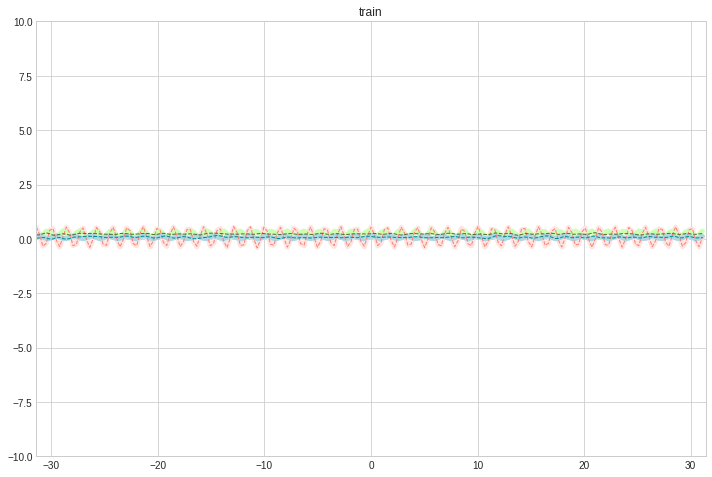

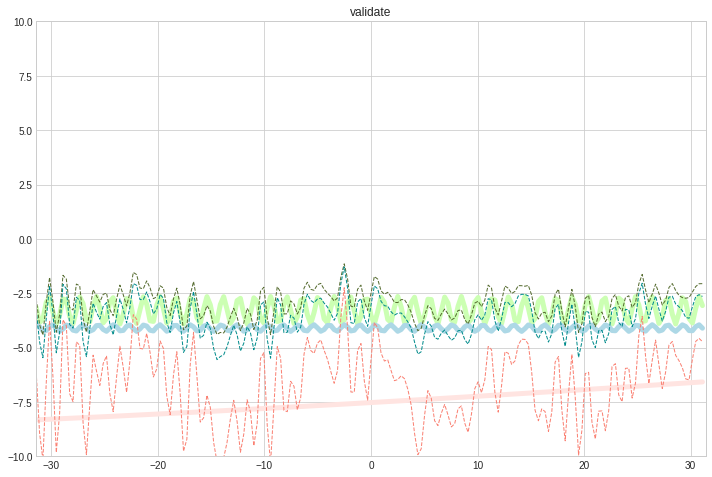

In [ ]:
wandb.init(project="sine_convnn", entity="sophied")
train_one_batch(10000)

In [ ]:
torch.save(model.state_dict(), 'one_batch.zip')

#train recon

In [ ]:
x = train_data[:, :200].mul(.1)
model = Starlight(10, {'w': 99, 'k': 7, 'p': 5, 's': 1}, {'w': 55, 'k': 3, 'p': 1, 's': 1}, 0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
def train_all(epochs, bs=64):
  batches = FastTensorDataLoader(x, batch_size=bs, shuffle=False)
  for epoch in range(epochs):
    for idx, batch in enumerate(batches):
      optimizer.zero_grad()
      ls, recon = model(batch[0])
      loss = torch.nn.MSELoss()(recon, batch[0])
      loss.backward(retain_graph=True)
      optimizer.step()
    if (epoch+1) % 10==0:
      print(loss)
    if (epoch+1) % (epochs/10) == 0:
      text = 'Loss '+ str(epoch+1)+ ': '+ str(loss.detach().numpy())
      optimizer.zero_grad()
      if loss > .005:
        plot_comp(np.random.randint(low=0, high=200), model(x[6500:6800, :200])[1], model(x[:500, :200])[1], text, epoch=str(epoch+1))
      else:
        plot_comp(np.random.randint(low=0, high=200), model(x[6500:6800, :200])[1], model(x[:500, :200])[1], text, epoch=str(epoch+1), col='green')
    if loss<0.01:
      torch.save(model.state_dict(), input('filename')+'.zip')
      break
  plot_reconstruction(train_data[:, :200], model(train_data[:, :200])[1])
  plot_reconstruction(validate_data[:, :200], model(validate_data[:, :200])[1])

In [ ]:
train_all(100, bs=128)

tensor(0.0443, grad_fn=<MseLossBackward0>)
tensor(0.0439, grad_fn=<MseLossBackward0>)
tensor(0.0365, grad_fn=<MseLossBackward0>)
tensor(0.0382, grad_fn=<MseLossBackward0>)
tensor(0.0383, grad_fn=<MseLossBackward0>)
tensor(0.0379, grad_fn=<MseLossBackward0>)
tensor(0.0362, grad_fn=<MseLossBackward0>)
tensor(0.0447, grad_fn=<MseLossBackward0>)
tensor(0.0353, grad_fn=<MseLossBackward0>)
tensor(0.0390, grad_fn=<MseLossBackward0>)


#Sweep

In [ ]:
inp = train_data[:100, :200].mul(.1)

def train_one_batch(epochs=100):
  with wandb.init(config=None):
    config=wandb.config
    model = Starlight(13, {'w': config.w1, 'k': config.k1, 'p': config.p1, 's': 1}, {'w': config.w2, 'k': config.k2, 'p': config.p2, 's': 1}, 0)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    for epoch in range(epochs):
      optimizer.zero_grad()
      ls, recon = model(inp)
      loss = torch.nn.MSELoss()(recon, inp)
      loss.backward(retain_graph=True)
      optimizer.step()
      wandb.log({'loss': loss})

In [ ]:
!pip install wandb
import wandb
!wandb login

wandb.init(project="conv_nn", entity="sophied")
sweep_config = {'method': 'bayes'}
metric = {'name': 'loss', 'goal': 'minimize'}
sweep_config['metric'] = metric
parameters_dict = {
    'lr': {
        'min': 0.0001,
        'max': 0.01,
        'distribution': 'uniform'
    },
    'w1': {'values': [11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77]},
    'w2': {'values': [11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51,53,55,57,59,61,63,65,67,69,71,73,75,77]},
    'k1': {'values': [3,5,7]},
    'k2': {'values': [3,5]},
    'p1': {'values': [2,3,4]},
    'p2': {'values': [2,3]}
}

sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="conv_nn")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Currently logged in as: sophied. Use `wandb login --relogin` to force relogin


epochs,▁
k,█▁
latent_dim,▁
loss,▆▂▂▂▂▁▄▅▆▃▃▅▂▂▃▂▂▃▅▃▃▃▂▄▂▂▄▅▄▄▃█▁▅▃▄▂▄▂▂
lr,▁
p,▁▁
s,▁▁
w,▁█
epochs,1000
k,3
latent_dim,10


Create sweep with ID: 2bsbb7zx
Sweep URL: https://wandb.ai/sophied/conv_nn/sweeps/2bsbb7zx


In [ ]:
wandb.agent(sweep_id, train_one_batch, count=1000)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: bq6b4udn with config:
wandb: 	k1: 3
wandb: 	k2: 5
wandb: 	lr: 0.005890106348682947
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 67
wandb: 	w2: 61


loss,▆▆▄▂▂▂▃▂▁▂▂▃▁▁▁▁▁▂▃▃▂▂▁▃▃▂█▂▂▁▂▁▂▁▁▁▂▁▂▁
loss,0.04905


wandb: Agent Starting Run: sqhrkvho with config:
wandb: 	k1: 5
wandb: 	k2: 3
wandb: 	lr: 0.009474358972617494
wandb: 	p1: 2
wandb: 	p2: 3
wandb: 	w1: 73
wandb: 	w2: 43


loss,████▇▇▃▂▁▂▂▂▁▂▃▄▂▅▁▂▁▂▂▃▂▁▁▂▁▂▁█▂▅▄▃▂▁▂▂
loss,0.04991


wandb: Agent Starting Run: gcn1m53v with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.0007284736866472002
wandb: 	p1: 2
wandb: 	p2: 2
wandb: 	w1: 15
wandb: 	w2: 75


wandb: ERROR Run gcn1m53v errored: RuntimeError('Given transposed=1, weight of size [75, 15, 5], expected input[1, 100, 149] to have 75 channels, but got 100 channels instead')
wandb: Agent Starting Run: 8c03npxp with config:
wandb: 	k1: 7
wandb: 	k2: 5
wandb: 	lr: 0.0008947617343358078
wandb: 	p1: 2
wandb: 	p2: 3
wandb: 	w1: 25
wandb: 	w2: 77


wandb: ERROR Run 8c03npxp errored: RuntimeError('Trying to create tensor with negative dimension -231: [13, -231]')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b88wkida with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.004323781784748916
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 73
wandb: 	w2: 59


wandb: ERROR Run b88wkida errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: 6nirzpcq with config:
wandb: 	k1: 3
wandb: 	k2: 3
wandb: 	lr: 0.008241703474695923
wandb: 	p1: 3
wandb: 	p2: 2
wandb: 	w1: 69
wandb: 	w2: 47


loss,▇▆▆▅▂▂▂▁▃▃▂▂█▂▂▃▂▁▂▁▂▃▂▂▁▁▃▂▂▂▁▂▂▁▂▁▂▁▂▂
loss,0.05065


wandb: Agent Starting Run: smp1az0b with config:
wandb: 	k1: 5
wandb: 	k2: 3
wandb: 	lr: 0.004816288010503262
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 37
wandb: 	w2: 47


wandb: ERROR Run smp1az0b errored: RuntimeError('Found an invalid max index: 5 (output volumes are of size 5x1')
wandb: Agent Starting Run: odp5lhml with config:
wandb: 	k1: 3
wandb: 	k2: 5
wandb: 	lr: 0.005895716960442917
wandb: 	p1: 4
wandb: 	p2: 2
wandb: 	w1: 51
wandb: 	w2: 15


wandb: ERROR Run odp5lhml errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: y19my63g with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.000968326233662346
wandb: 	p1: 3
wandb: 	p2: 2
wandb: 	w1: 47
wandb: 	w2: 55


wandb: ERROR Run y19my63g errored: RuntimeError('Given transposed=1, weight of size [55, 47, 5], expected input[1, 100, 109] to have 55 channels, but got 100 channels instead')
wandb: Agent Starting Run: ij0sb9db with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.008455030601852752
wandb: 	p1: 4
wandb: 	p2: 2
wandb: 	w1: 69
wandb: 	w2: 53


loss,█▇▃▁▂▁▆▆▃▆▁▁▁▂▂▇▂▅▃▁▃▂▄▄▂▂▁▂▅▃▃▂▇▁▃▃▂▂▂▁
loss,0.0449


wandb: Agent Starting Run: y2er7rms with config:
wandb: 	k1: 5
wandb: 	k2: 3
wandb: 	lr: 0.002951053631158628
wandb: 	p1: 4
wandb: 	p2: 3
wandb: 	w1: 67
wandb: 	w2: 51


loss,▆▆▃▂▁▁▂▁▂▂▃▁▂▁▁█▂▃▂▁▁▁▁▂▁▃▁▁▁▁▁▁▃▂▂▁▁▁▃▂
loss,0.0518


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vccr41s with config:
wandb: 	k1: 3
wandb: 	k2: 3
wandb: 	lr: 0.0013067121940917626
wandb: 	p1: 2
wandb: 	p2: 2
wandb: 	w1: 23
wandb: 	w2: 35


wandb: ERROR Run 2vccr41s errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: k0qa7ehd with config:
wandb: 	k1: 3
wandb: 	k2: 3
wandb: 	lr: 0.008799589679851838
wandb: 	p1: 3
wandb: 	p2: 2
wandb: 	w1: 47
wandb: 	w2: 25


loss,██▇▆▄▂▄▂▂▂▂▁▁▁▁▂▂▃▄▄▁▂▃▄▂▁▂▂▂▂▃▃▁▂▁▄▃▃▁▁
loss,0.04293


wandb: Agent Starting Run: o004sioh with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.001847223517490991
wandb: 	p1: 3
wandb: 	p2: 3
wandb: 	w1: 11
wandb: 	w2: 59


wandb: ERROR Run o004sioh errored: RuntimeError('Found an invalid max index: 3 (output volumes are of size 3x1')
wandb: Agent Starting Run: e0ig3nsc with config:
wandb: 	k1: 5
wandb: 	k2: 5
wandb: 	lr: 0.006849868067554599
wandb: 	p1: 4
wandb: 	p2: 3
wandb: 	w1: 65
wandb: 	w2: 75


loss,█▇▂▃▂▃▄▂▅▁▃▁▁▂▁▅▃▂▁▂▃▅▄▁▅▁█▄▅▅▄▃▁▄▆▄▁▃▂▇
loss,0.10913
